In [3]:
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [4]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

In [128]:
train_transform = transforms.Compose([
    transforms.RandomVerticalFlip(),
    transforms.RandomAutocontrast(),
    transforms.ToTensor()
])

data_train = datasets.CIFAR10(
    root='../data',
    train=True,
    download=False,
    transform=train_transform
)

data_test = datasets.CIFAR10(
    root='../data',
    train=False,
    download=False,
    transform=transforms.ToTensor()
)

In [129]:
train_loader = DataLoader(data_train, batch_size=16, shuffle=True)
test_loader = DataLoader(data_test, batch_size=16, shuffle=True)

In [130]:
def transform_to_gray(image: torch.Tensor):
    if len == 3:
        image = image.unsqueeze(dim=0)
    gray_transform = transforms.Grayscale(1)
    return gray_transform(image)

In [131]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, sc_layer=None):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.last_relu = nn.ReLU(inplace=True)

        self.sc_layer = sc_layer
    def forward(self, x):
        sc = x

        if self.sc_layer:
            sc = self.sc_layer(x.clone())

        out = self.conv_layers(x)

        out += sc

        return self.last_relu(out)

In [132]:
class ColorizationModel(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()

        def encoder(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        def decoder(in_channels, out_channels):
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        
        self.res1 = self._make_res_block(in_channels, 64, 1)
        self.enc1 = encoder(64, 128)
        self.enc2 = encoder(128, 256)

        self.res2 = self._make_res_block(256, 512, 1)
        self.enc3 = encoder(512, 1024)
        
        self.dec1 = decoder(1024, 512)
        self.dec2 = decoder(512, 256)
        self.dec3 = decoder(256, 128)
        self.unres1 = nn.ConvTranspose2d(128, 64, kernel_size=1, stride=1, padding=0, output_padding=0)

        self.dec4 = nn.ConvTranspose2d(64, out_channels, kernel_size=1, stride=1, padding=0, output_padding=0)

    def _make_res_block(self, in_channels, out_channels, stride):
        if stride != 1 or in_channels != out_channels:
            sc_layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        return ResidualBlock(in_channels, out_channels, stride, sc_layer)

    def forward(self, x):
        x = self.res1(x)
        x = self.enc1(x)
        x = self.enc2(x)   
        x = self.res2(x)
        x = self.enc3(x)

        x = self.dec1(x)
        x = self.dec2(x)
        x = self.dec3(x)
        x = self.unres1(x)
        x = self.dec4(x)

        return x

In [134]:
model = ColorizationModel(1, 3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

In [135]:
def train(model: ColorizationModel, loss_fn: nn.MSELoss, optimizer: torch.optim.Adam, 
          train_loader: DataLoader, test_loader: DataLoader, device, epoches=3):
    
    train_size = len(train_loader.dataset)
    test_size = len(test_loader.dataset)

    for epoch in range(epoches):
        train_loss = 0
        test_loss = 0

        model.train()
        for img, _ in train_loader:
            img: torch.Tensor
            img = img.to(device)

            gray_img = transform_to_gray(img)
            rec_img = model(gray_img)

            loss: torch.Tensor = loss_fn(rec_img, img)
            train_loss += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        model.eval()
        with torch.no_grad():
            for img, _ in test_loader:
                img: torch.Tensor
                img = img.to(device)

                gray_img = transform_to_gray(img)
                rec_img = model(gray_img)

                loss: torch.Tensor = loss_fn(rec_img, img)
                test_loss += loss.item()

        train_loss = train_loss / train_size
        test_loss = test_loss / test_size

        print(f'Epoch: {epoch}/{epoches} | train loss = {train_loss} | test loss = {test_loss}')

In [165]:
def display_results(model: ColorizationModel, data, device):
    model.eval()

    random_data = torch.randint(low=0, high=len(data), size=(1,))
    image: torch.Tensor = data[random_data][0]
    gray_image: torch.Tensor = transform_to_gray(image)

    rec_image: torch.Tensor = model(gray_image.unsqueeze(dim=0).to(device))
    rec_image = rec_image.squeeze().permute(1, 2, 0).cpu().detach()

    rec_image = torch.clamp(rec_image, 0, 1).numpy()

    # Plot the images
    fig, axes = plt.subplots(1, 3, figsize=(4, 4))
    axes[0].imshow(image.permute(1, 2, 0).numpy())
    axes[0].set_title("Original")
    axes[1].imshow(gray_image.permute(1, 2, 0).numpy(), cmap='gray')
    axes[1].set_title("Grayscale")
    axes[2].imshow(rec_image)
    axes[2].set_title("Colorized")
    plt.show()

    print("\nReal Image Tensor:", image)
    print("\nColorized Image Tensor:", rec_image)

In [137]:
train(model, loss_fn, optimizer, train_loader, test_loader, device, 3)

Epoch: 0/3 | train loss = 0.004213889904487878 | test loss = 0.0006600922199431807
Epoch: 1/3 | train loss = 0.0007066820173244924 | test loss = 0.0004806492284871638
Epoch: 2/3 | train loss = 0.0005477082849293947 | test loss = 0.0004956780821550637


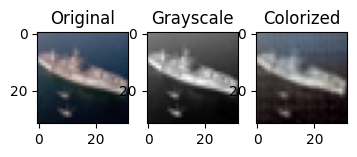


Real Image Tensor: tensor([[[0.3922, 0.3843, 0.3843,  ..., 0.2706, 0.2627, 0.2588],
         [0.3843, 0.3725, 0.3686,  ..., 0.2549, 0.2510, 0.2471],
         [0.3686, 0.3608, 0.3608,  ..., 0.2471, 0.2431, 0.2353],
         ...,
         [0.0510, 0.0471, 0.0471,  ..., 0.0157, 0.0196, 0.0157],
         [0.0471, 0.0549, 0.0353,  ..., 0.0118, 0.0118, 0.0196],
         [0.0549, 0.0471, 0.0353,  ..., 0.0157, 0.0157, 0.0196]],

        [[0.4353, 0.4314, 0.4275,  ..., 0.3490, 0.3412, 0.3373],
         [0.4275, 0.4157, 0.4118,  ..., 0.3333, 0.3294, 0.3255],
         [0.4118, 0.4039, 0.4039,  ..., 0.3255, 0.3216, 0.3137],
         ...,
         [0.1059, 0.1020, 0.1020,  ..., 0.0235, 0.0275, 0.0275],
         [0.0941, 0.1020, 0.0824,  ..., 0.0196, 0.0196, 0.0275],
         [0.0902, 0.0824, 0.0745,  ..., 0.0157, 0.0196, 0.0196]],

        [[0.5255, 0.5176, 0.5137,  ..., 0.4471, 0.4431, 0.4353],
         [0.5137, 0.5020, 0.4980,  ..., 0.4314, 0.4275, 0.4196],
         [0.4980, 0.4902, 0.4902,  ...

In [192]:
display_results(model, data_test, device)

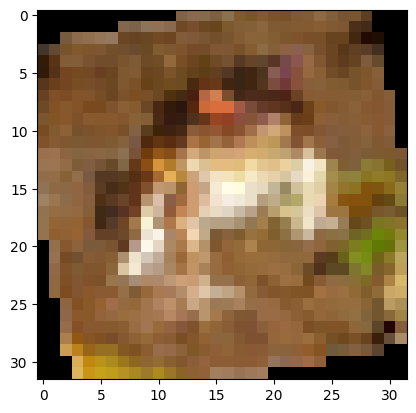

In [127]:
plt.imshow(data_train[0][0].permute(1, 2, 0))